In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.calibration import CalibratedClassifierCV
from scipy import ndimage
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import neighbors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import gzip
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import time


In [2]:
def read_image_file(filename, images):
    width = 28
    height = 28
    N = images

    f = gzip.open(filename, 'r')
    f.read(16) # skip preamble, 16 bytes
    buffer = f.read(width * height * N) # read in "N" images as binary data
    data = np.frombuffer(buffer, dtype='uint8') # convert binary data to integers : 0 - 255
    data = data.reshape(N, width, height, 1) # reshape to Nx28x28x1 (only 1 color channel, b/w)
    f.close()

    return data

def read_label_file(filename, labels):
    N = labels
    
    f = gzip.open(filename, 'r')
    f.read(8) # skip preamble, 8 bytes
    buffer = f.read(N) # read in "N" labels as binary data
    data = np.frombuffer(buffer, dtype='uint8') # convert binary data to integers : 0 - 255
    f.close()
    
    return data

In [3]:
X_train = read_image_file('train-images-idx3-ubyte.gz', 60_000)
y_train = read_label_file('train-labels-idx1-ubyte.gz', 60_000)
X_test = read_image_file('t10k-images-idx3-ubyte.gz', 10_000)
y_test = read_label_file('t10k-labels-idx1-ubyte.gz', 10_000)

X_train = X_train.reshape(60_000, 28*28)
X_test = X_test.reshape(10_000, 28*28)

# Reformat the images from 0-255 integers to 0-1 floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# Print the shape of the new images
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)
print("Label shape X", y_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)
Label shape X (10000,)


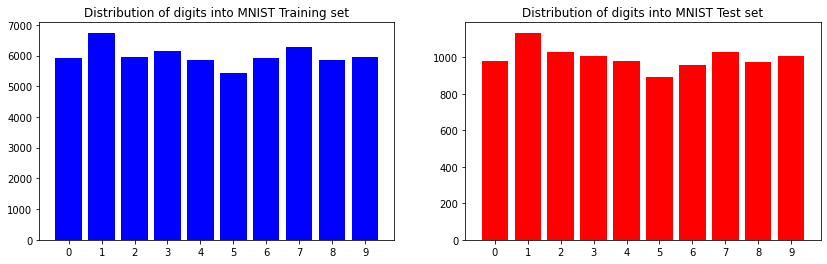

In [4]:
digit_cnt_tr = np.zeros(10)
for item in y_train:
    digit_cnt_tr[item] += 1

digit_cnt_te = np.zeros(10)
for item in y_test:
    digit_cnt_te[item] += 1

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))

ax1.bar(np.arange(len(digit_cnt_tr)), digit_cnt_tr, color='blue')
ax1.set_xticks(np.arange(len(digit_cnt_tr)))
ax1.set_title('Distribution of digits into MNIST Training set')

ax2.bar(np.arange(len(digit_cnt_te)), digit_cnt_te, color='red')
ax2.set_xticks(np.arange(len(digit_cnt_te)))
ax2.set_title('Distribution of digits into MNIST Test set')

plt.show()



MEAN GRAPH


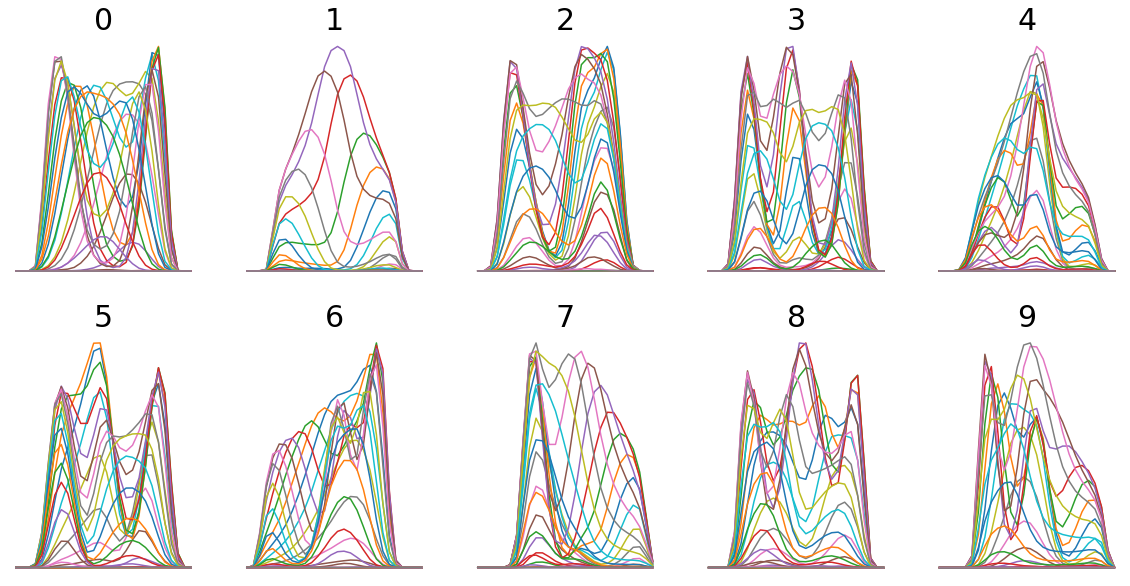

In [5]:
print('\n\nMEAN GRAPH')
X = X_train
y = y_train
u = np.zeros((10, 784))
plt.figure(figsize=(20,10))
for i in range(10):
    u[i] = np.mean(X[y==i], 0)
    plt.subplot(2,5,i+1)
    plt.plot(u[i].reshape(28, 28))
    plt.axis('off')
    plt.title(str(i), fontsize=30)
plt.show()

[0.9691]
K-value: 1/10 and took 387.26s
[0.9691, 0.9627]
K-value: 2/10 and took 424.47s
[0.9691, 0.9627, 0.9705]
K-value: 3/10 and took 448.55s
[0.9691, 0.9627, 0.9705, 0.9682]
K-value: 4/10 and took 461.11s
[0.9691, 0.9627, 0.9705, 0.9682, 0.9688]
K-value: 5/10 and took 483.53s
[0.9691, 0.9627, 0.9705, 0.9682, 0.9688, 0.9677]
K-value: 6/10 and took 425.42s
[0.9691, 0.9627, 0.9705, 0.9682, 0.9688, 0.9677, 0.9694]
K-value: 7/10 and took 395.15s
[0.9691, 0.9627, 0.9705, 0.9682, 0.9688, 0.9677, 0.9694, 0.967]
K-value: 8/10 and took 441.97s
[0.9691, 0.9627, 0.9705, 0.9682, 0.9688, 0.9677, 0.9694, 0.967, 0.9659]
K-value: 9/10 and took 448.64s
[0.9691, 0.9627, 0.9705, 0.9682, 0.9688, 0.9677, 0.9694, 0.967, 0.9659, 0.9665]
K-value: 10/10 and took 442.41s
Total time elapsed: 4358.53s


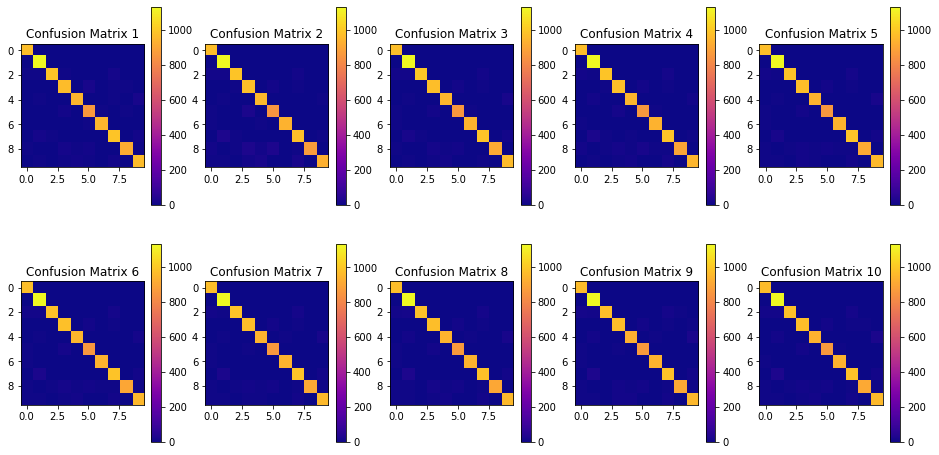

In [8]:
error = []
test_accuracy = []
valid_accuracy = []
predictions = []
X = X_train.reshape(-1,28*28)
y = y_train
neighbor_range = 10
plt.figure(figsize=(16,8))
t0 = time.time()
for i in range(1,neighbor_range+1):
    ti = time.time()
    clf = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    clf.fit(X, y)
    pred_i = clf.predict(X_test.reshape(-1,28*28))
    predictions.append(pred_i)
    error.append(np.mean(pred_i != y_test))
    test_accuracy.append(metrics.accuracy_score(y_test, pred_i))
    print(test_accuracy)
    cnf_matrix = metrics.confusion_matrix(y_test,pred_i)
    #print(cnf_matrix)
    # Plot non-normalized confusion matrix
    plt.subplot(2,neighbor_range/2,i)
    plt.imshow(cnf_matrix, cmap='plasma')
    plt.title("Confusion Matrix {}".format(i))
    plt.colorbar()
    
    print('K-value: {}/{} and took %.2fs'.format(i, neighbor_range) % (time.time()-ti))
print('Total time elapsed: %.2fs' % (time.time()-t0))

Highest test accuracy: 0.9705 with k-value of 3


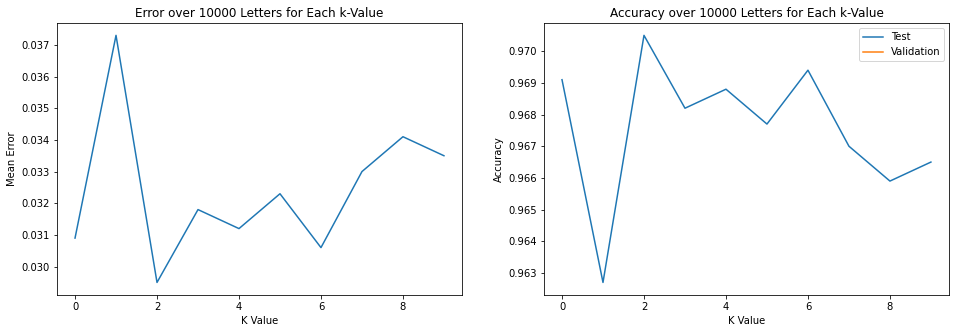

In [9]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(error)
plt.title('Error over {} Letters for Each k-Value'.format(len(predictions[0])))  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')

plt.subplot(1,2,2)
plt.plot(test_accuracy)
plt.plot(valid_accuracy)
plt.title('Accuracy over {} Letters for Each k-Value'.format(len(predictions[0])))  
plt.xlabel('K Value')  
plt.ylabel('Accuracy')
plt.legend(['Test', 'Validation'])

print("Highest test accuracy: {} with k-value of {}"
      .format(max(test_accuracy), test_accuracy.index(max(test_accuracy))+1))


In [7]:
clf = neighbors.KNeighborsClassifier(3)
clf.fit(X, y)
y_pred = clf.predict(X_test.reshape(-1,28*28))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.96      1.00      0.98      1135
           2       0.98      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



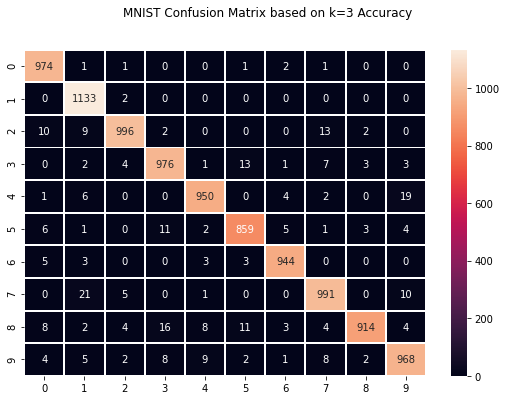


Accuracy of Classifier on Test Images:  0.9705


,Accuracy
Digit 0,99.387755
Digit 1,99.823789
Digit 2,96.511628
Digit 3,96.633663
Digit 4,96.741344
Digit 5,96.300448
Digit 6,98.538622
Digit 7,96.400778
Digit 8,93.839836
Digit 9,95.936571


In [8]:
# The accuracy is found using unique digits and their respective count from test set and comparing that with confusion matrix 
unique, counts = np.unique(y_test, return_counts=True)
counts=counts.tolist()

cm1 = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(9, 6))
sns.heatmap(cm1, linewidths=.9, annot=True, fmt='g')
plt.suptitle('MNIST Confusion Matrix based on k=3 Accuracy')
plt.show()

acc = metrics.accuracy_score(y_test,y_pred)
print('\nAccuracy of Classifier on Test Images: ',acc)

a=cm1.diagonal()
acc={}
# The accuracy is found using unique digits and their respective count from test set and comparing that with confusion matrix
unique_elements, counts_elements = np.unique(y_test, return_counts=True)
for i in range(0,len(a)):
    e=[]
    e.append((a[i]/counts[i])*100)
    acc[i]=e
column=[]
for i in range(0,10):
    column.append('Digit %d'%i)    
acc=pd.DataFrame(acc)
acc.columns=column
acc=acc.T
acc.columns=['Accuracy']
acc

Train Size: 60000 Test_Size: 10000
[0.9705]
Train Size: 1/10 and took 444.21s
Train Size: 30000 Test_Size: 10000
[0.9705, 0.9624]
Train Size: 2/10 and took 150.76s
Train Size: 15000 Test_Size: 10000
[0.9705, 0.9624, 0.9527]
Train Size: 3/10 and took 101.03s
Train Size: 7500 Test_Size: 10000
[0.9705, 0.9624, 0.9527, 0.9411]
Train Size: 4/10 and took 43.83s
Train Size: 3750 Test_Size: 10000
[0.9705, 0.9624, 0.9527, 0.9411, 0.925]
Train Size: 5/10 and took 25.36s
Train Size: 1875 Test_Size: 10000
[0.9705, 0.9624, 0.9527, 0.9411, 0.925, 0.8977]
Train Size: 6/10 and took 14.08s
Train Size: 937 Test_Size: 10000
[0.9705, 0.9624, 0.9527, 0.9411, 0.925, 0.8977, 0.8571]
Train Size: 7/10 and took 6.98s
Train Size: 468 Test_Size: 10000
[0.9705, 0.9624, 0.9527, 0.9411, 0.925, 0.8977, 0.8571, 0.798]
Train Size: 8/10 and took 2.82s
Train Size: 234 Test_Size: 10000
[0.9705, 0.9624, 0.9527, 0.9411, 0.925, 0.8977, 0.8571, 0.798, 0.7293]
Train Size: 9/10 and took 2.04s
KNeighborsClassifier(algorithm='aut

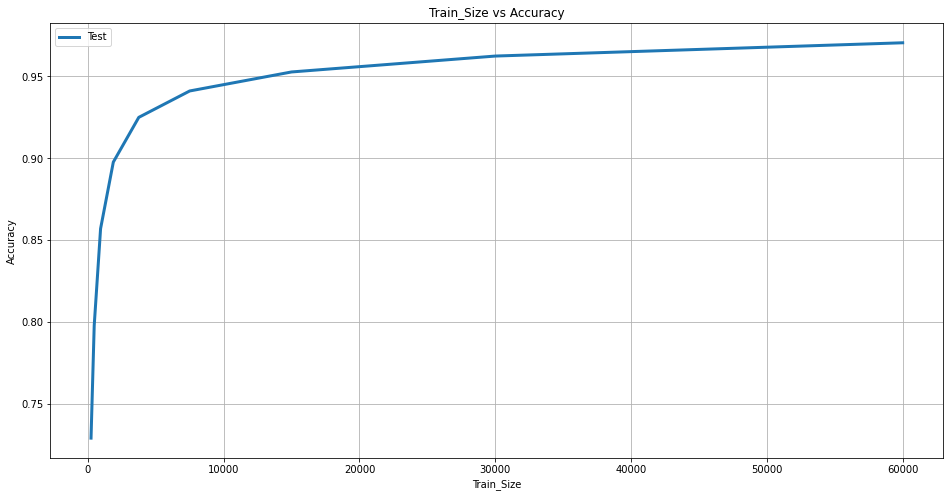

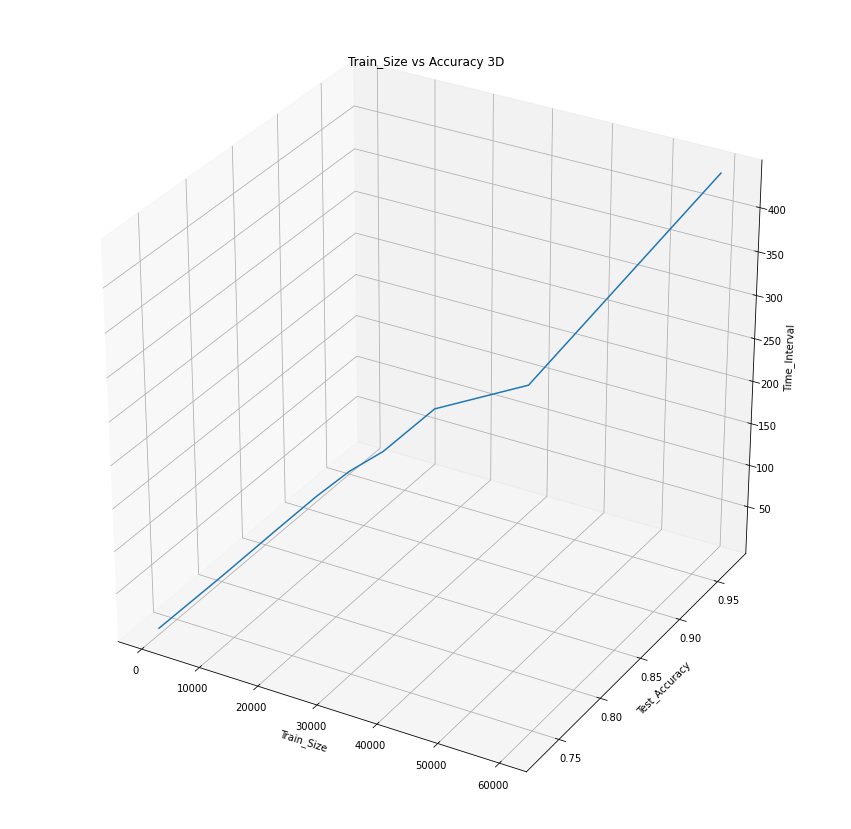

In [12]:
Tn_S = 60_000
Tt_S = 10_000 

test_accuracy = []
train_size = []
time_interval = []
depth_range = 10
t0 = time.time()
for i in range(1, depth_range):
    ti = time.time()
    train_size.append(Tn_S)
    print('Train Size: ' + str(Tn_S) + ' ' + 'Test_Size: ' + str(Tt_S))
    X_train = read_image_file('train-images-idx3-ubyte.gz', Tn_S)
    y_train = read_label_file('train-labels-idx1-ubyte.gz', Tn_S)
    X_test = read_image_file('t10k-images-idx3-ubyte.gz', Tt_S)
    y_test = read_label_file('t10k-labels-idx1-ubyte.gz', Tt_S)
    
    clf_dt_depth = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
    
    clf_dt_depth.fit(X_train.reshape(-1,28*28), y_train)
    
    test_pred_dt = clf_dt_depth.predict(X_test.reshape(-1,28*28))

    test_accuracy.append(metrics.accuracy_score(y_test, test_pred_dt))
    print(test_accuracy)
    print('Train Size: {}/{} and took %.2fs'.format(i,depth_range) % (time.time()-ti))
    Tn_S = Tn_S/2 
    Tn_S = int(Tn_S)
    time_interval.append(time.time()-ti)
print(clf_dt_depth.fit(X_train.reshape(-1,28*28), y_train))
print('Time elapsed: %.2fs' % (time.time()-t0))

plt.figure(figsize=(16,8))
plt.title('Train_Size vs Accuracy')
plt.xlabel('Train_Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(train_size,test_accuracy, lw=3)
plt.legend(['Test'])
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Train_Size vs Accuracy 3D')
ax.set_xlabel('Train_Size')
ax.set_ylabel('Test_Accuracy')
ax.set_zlabel('Time_Interval')
ax.plot3D(train_size,test_accuracy,time_interval)

Train Size: 60000 Test_Size: 10000
[0.9705]
Train Size: 1/6 and took 487.60s
Train Size: 60000 Test_Size: 5000
[0.9705, 0.9568]
Train Size: 2/6 and took 258.61s
Train Size: 60000 Test_Size: 2500
[0.9705, 0.9568, 0.9532]
Train Size: 3/6 and took 144.94s
Train Size: 60000 Test_Size: 1250
[0.9705, 0.9568, 0.9532, 0.9584]
Train Size: 4/6 and took 101.84s
Train Size: 60000 Test_Size: 625
[0.9705, 0.9568, 0.9532, 0.9584, 0.9648]
Train Size: 5/6 and took 75.41s
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform')
Time elapsed: 1123.38s


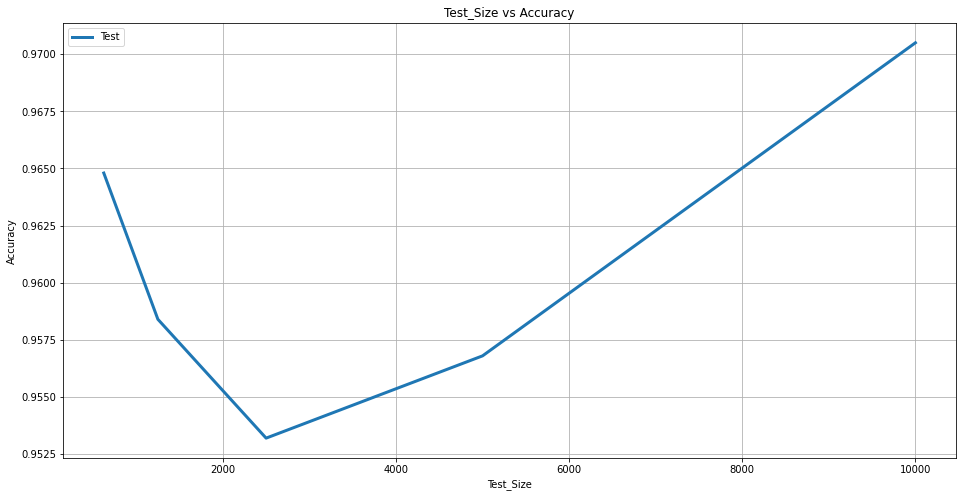

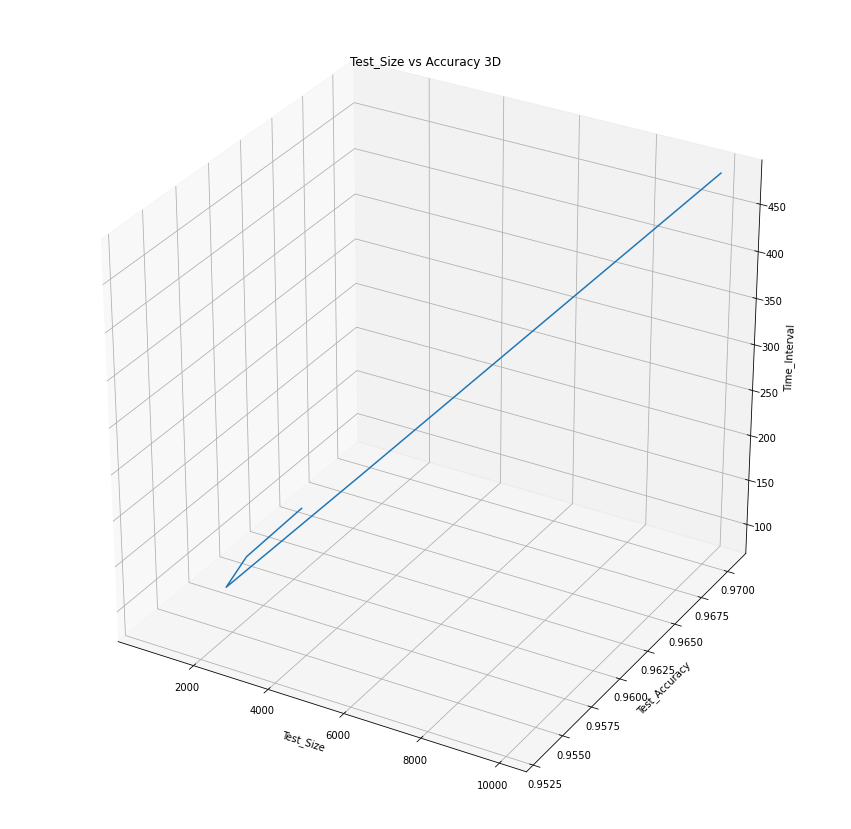

In [13]:
Tn_S = 60_000
Tt_S = 10_000 

test_accuracy = []
test_size = []
time_interval = []
depth_range = 6
t0 = time.time()
for i in range(1, depth_range):
    ti = time.time()
    test_size.append(Tt_S)
    print('Train Size: ' + str(Tn_S) + ' ' + 'Test_Size: ' + str(Tt_S))
    X_train = read_image_file('train-images-idx3-ubyte.gz', Tn_S)
    y_train = read_label_file('train-labels-idx1-ubyte.gz', Tn_S)
    X_test = read_image_file('t10k-images-idx3-ubyte.gz', Tt_S)
    y_test = read_label_file('t10k-labels-idx1-ubyte.gz', Tt_S)
    
    clf_dt_depth = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
    
    clf_dt_depth.fit(X_train.reshape(-1,28*28), y_train)
    
    test_pred_dt = clf_dt_depth.predict(X_test.reshape(-1,28*28))

    test_accuracy.append(metrics.accuracy_score(y_test, test_pred_dt))
    print(test_accuracy)
    print('Train Size: {}/{} and took %.2fs'.format(i,depth_range) % (time.time()-ti))
    Tt_S = Tt_S/2 
    Tt_S = int(Tt_S)
    time_interval.append(time.time()-ti)
print(clf_dt_depth.fit(X_train.reshape(-1,28*28), y_train))
print('Time elapsed: %.2fs' % (time.time()-t0))

plt.figure(figsize=(16,8))
plt.title('Test_Size vs Accuracy')
plt.xlabel('Test_Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(test_size,test_accuracy, lw=3)
plt.legend(['Test'])
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Test_Size vs Accuracy 3D')
ax.set_xlabel('Test_Size')
ax.set_ylabel('Test_Accuracy')
ax.set_zlabel('Time_Interval')
ax.plot3D(test_size,test_accuracy,time_interval)

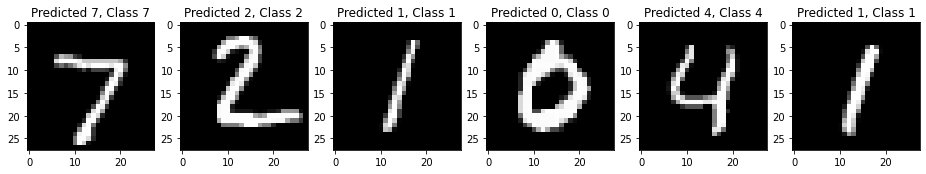

In [14]:
correct_indices_d = np.nonzero(test_pred_dt == y_test)[0]
num_figures = 6
plt.figure(figsize=(16,8))
for i, correct in enumerate(correct_indices_d[:num_figures]):
    plt.subplot(1,num_figures,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(test_pred_dt[correct], y_test[correct]))

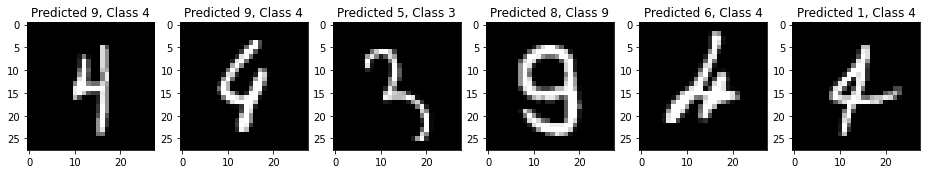

In [15]:
incorrect_indices_d = np.nonzero(test_pred_dt != y_test)[0]
num_figures = 6
plt.figure(figsize=(16,8))
for i, incorrect in enumerate(incorrect_indices_d[:num_figures]):
    plt.subplot(1,num_figures,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(test_pred_dt[incorrect], y_test[incorrect]))